## An End to End Example

 http://localhost:4040.

In [1]:
# PYSPARK INITIALIZATION
import os
import sys

APP_NAME = 'pyspark_python'
MASTER = 'local[*]'


In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession


conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

In [3]:

flightData2015 = spark\
.read\
.option("inferSchema", "true")\
.option("header", "true")\
.csv("Spark-The-Definitive-Guide-master/data/flight-data/csv/2015-summary.csv") 

In [4]:
flightData2015.toPandas().head()

,DEST_COUNTRY_NAME,ORIGIN_COUNTRY_NAME,count
0,United States,Romania,15
1,United States,Croatia,1
2,United States,Ireland,344
3,Egypt,United States,15
4,United States,India,62


## EXPLAIN 
* Nothing hpapens to the data when we call sort because it’s just a transformation. However, we can see that Spark is
building up a plan for how it will execute this across the cluster by looking at the explain plan. We can call explain on any DataFrame object to see the DataFrame’s lineage (or how Spark will execute this query).

* Note that sort of our data is actually a wide transformation because rows will have to be
compared with one another.

In [5]:

flightData2015.sort("count").explain()

== Physical Plan ==
*(2) Sort [count#12 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(count#12 ASC NULLS FIRST, 200)
   +- *(1) FileScan csv [DEST_COUNTRY_NAME#10,ORIGIN_COUNTRY_NAME#11,count#12] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/erikapat/Dropbox/conento/conento_prueba/PRUEBA DATA ARQUITECT/Churn...., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>


By default, when we perform a shuffle Spark will output two hundred shuffle partitions. We
will set this value to five in order to reduce the number of the output partitions from the shuffle from two hundred to five.

Go ahead and experiment with different values and see the number of partitions yourself. In experimenting with
different values, you should see drastically different run times. Remeber that you can monitor the job progress by
navigating to the Spark UI on port 4040 to see the physical and logical execution characteristics of our jobs.

In [6]:
import datetime
#Calculamos el tiempo de ejecucion
timestart= datetime.datetime.now()
spark.conf.set("spark.sql.shuffle.partitions", "1")
flightData2015.sort("count").take(2)

# Calculamos el tiempo empleado en la ejecución
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print("Tiempo tomado en crear el modelo: " + str(timedelta) + " segundos")

Tiempo tomado en crear el modelo: 0.19 segundos


In [7]:
import datetime
#Calculamos el tiempo de ejecucion
timestart= datetime.datetime.now()
spark.conf.set("spark.sql.shuffle.partitions", "5")
flightData2015.sort("count").take(2)

# Calculamos el tiempo empleado en la ejecución
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print("Tiempo tomado en crear el modelo: " + str(timedelta) + " segundos")

Tiempo tomado en crear el modelo: 0.15 segundos


In [8]:
import datetime
#Calculamos el tiempo de ejecucion
timestart= datetime.datetime.now()
spark.conf.set("spark.sql.shuffle.partitions", "20")
flightData2015.sort("count").take(2)

# Calculamos el tiempo empleado en la ejecución
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print("Tiempo tomado en crear el modelo: " + str(timedelta) + " segundos")

Tiempo tomado en crear el modelo: 0.16 segundos


In [9]:
import datetime
#Calculamos el tiempo de ejecucion
timestart= datetime.datetime.now()
spark.conf.set("spark.sql.shuffle.partitions", "100")
flightData2015.sort("count").take(2)

# Calculamos el tiempo empleado en la ejecución
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print("Tiempo tomado en crear el modelo: " + str(timedelta) + " segundos")

Tiempo tomado en crear el modelo: 0.15 segundos


# DataFrames and SQL

There is no performance difference between writing SQL queries or writing DataFrame code, they
both "compile" to the same underlying plan that we specify in DataFrame code.

**Any DataFrame can be made into a table or view with one simple method call**

In [10]:
flightData2015.createOrReplaceTempView("flight_data_2015")

To execute a SQL query, we’ll use the spark.sql function (remember spark
is our SparkSession variable?) that conveniently, returns a new DataFrame. While this may seem a bit circular in logic
- that a SQL query against a DataFrame returns another DataFrame, it’s actually quite powerful.

In [11]:
sqlWay = spark.sql("""
SELECT DEST_COUNTRY_NAME, count(1)
FROM flight_data_2015
GROUP BY DEST_COUNTRY_NAME
""")
sqlWay.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#10, 100)
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[partial_count(1)])
      +- *(1) FileScan csv [DEST_COUNTRY_NAME#10] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/erikapat/Dropbox/conento/conento_prueba/PRUEBA DATA ARQUITECT/Churn...., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>


In [12]:
sqlWay.toPandas().head()

,DEST_COUNTRY_NAME,count(1)
0,Panama,1
1,Cape Verde,1
2,Hong Kong,1
3,Anguilla,1
4,Russia,1


In [13]:
dataFrameWay = flightData2015\
.groupBy("DEST_COUNTRY_NAME")\
.count()
dataFrameWay.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#10, 100)
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#10], functions=[partial_count(1)])
      +- *(1) FileScan csv [DEST_COUNTRY_NAME#10] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/erikapat/Dropbox/conento/conento_prueba/PRUEBA DATA ARQUITECT/Churn...., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>


In [14]:
dataFrameWay.toPandas().head()

,DEST_COUNTRY_NAME,count
0,Panama,1
1,Cape Verde,1
2,Hong Kong,1
3,Anguilla,1
4,Russia,1


In [15]:
from pyspark.sql.functions import desc
flightData2015\
.groupBy("DEST_COUNTRY_NAME")\
.sum("count")\
.withColumnRenamed("sum(count)", "destination_total")\
.sort(desc("destination_total"))\
.limit(5)\
.collect()

[Row(DEST_COUNTRY_NAME='United States', destination_total=411352),
 Row(DEST_COUNTRY_NAME='Canada', destination_total=8399),
 Row(DEST_COUNTRY_NAME='Mexico', destination_total=7140),
 Row(DEST_COUNTRY_NAME='United Kingdom', destination_total=2025),
 Row(DEST_COUNTRY_NAME='Japan', destination_total=1548)]

## Structured Streaming

Structured Streaming is a high-level API for stream processing that became production-ready in Spark 2.2. Structured
Streaming allows you to take the same operations that you perform in batch mode using Spark’s structured APIs, and
run them in a streaming fashion. 

This can reduce latency and allow for incremental processing. The best thing about
Structured Streaming is that it allows you to rapidly and quickly get value out of streaming systems with virtually no code changes. 

It also makes it easy to reason about because you can write your batch job as a way to prototype it and
then you can convert it to streaming job. 

The way all of this works is by incrementally processing that data.
Let’s walk through a simple example of how easy it is to get started with Structured Streaming. For this we will use a retail dataset. One that has specific dates and times for us to be able to use. We will use the "by-day" set of files where one file represents one day of data.

We put it in this format to simulate data being produced in a consistent and regular manner by a different process.
Now this is retail data so imagine that these are being produced by retail stores and sent to a location where they will be read by our Structured Streaming job.

In [16]:
staticDataFrame = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load("Spark-The-Definitive-Guide-master/data/retail-data/by-day/*.csv")
staticDataFrame.createOrReplaceTempView("retail_data")
staticSchema = staticDataFrame.schema

Now since we’re working with time series data it’s worth mentioning how we might go along grouping and
aggregating our data. In this example we’ll take a look at the largest sale hours where a given customer (identified by
CustomerId) makes a large purchase. For example, let’s add a total cost column and see on what days a customer
spent the most.

In [17]:
from pyspark.sql.functions import window, column, desc, col
staticDataFrame\
.selectExpr(
"CustomerId",
"(UnitPrice * Quantity) as total_cost" ,
"InvoiceDate" )\
.groupBy(
col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
.sum("total_cost")\
.show(5)

+----------+--------------------+-------------------+
|CustomerId|              window|    sum(total_cost)|
+----------+--------------------+-------------------+
|   16057.0|[2011-12-05 01:00...|              -37.6|
|   14126.0|[2011-11-29 01:00...|  643.6300000000001|
|   13500.0|[2011-11-16 01:00...|  497.9700000000001|
|   16253.0|[2011-11-08 01:00...|-18.240000000000002|
|   17160.0|[2011-11-08 01:00...|  516.8499999999999|
+----------+--------------------+-------------------+
only showing top 5 rows



That’s the static DataFrame version, there shouldn’t be any big surprises in there if you’re familiar with the syntax.
Now we’ve seen how that works, let’s take a look at the streaming code! You’ll notice that very little actually changes
about our code. The biggest change is that we used readStream instead of read, additionally you’ll notice
maxFilesPerTrigger option which simply specifies the number of files we should read in at once. This is to make
our demonstration more "streaming" and in a production scenario this would be omitted.

Now since you’re likely running this in local mode, it’s a good practice to set the number of shuffle partitions to
something that’s going to be a better fit for local mode. This configuration simple specifies the number of partitions
that should be created after a shuffle, by default the value is two hundred but since there aren’t many executors
on this machine it’s worth reducing this to five.

`spark.conf.set("spark.sql.shuffle.partitions", "5")`

In [18]:
streamingDataFrame = spark.readStream\
.schema(staticSchema)\
.option("maxFilesPerTrigger", 1)\
.format("csv")\
.option("header", "true")\
.load("Spark-The-Definitive-Guide-master/data/retail-data/by-day/*.csv")

In [19]:
streamingDataFrame.isStreaming

True

Now we can see the DataFrame is streaming.

Let’s set up the same business logic as the previous DataFrame manipulation, we’ll perform a summation in the process.

In [20]:
purchaseByCustomerPerHour = streamingDataFrame\
.selectExpr(
"CustomerId",
"(UnitPrice * Quantity) as total_cost" ,
"InvoiceDate" )\
.groupBy(
col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
.sum("total_cost")

This is still a lazy operation, so we will need to call a streaming action to start the execution of this data flow.

## NOTE
Before kicking off the stream, we will set a small optimization that will allow this to run better on a single machine.
This simply limits the number of output partitions after a shuffle, a concept we discussed in the last chapter. We
discuss this in Part VI of the book.

In [21]:
spark.conf.set("spark.sql.shuffle.partitions", "5")

Streaming actions are a bit different from our conventional static action because we’re going to be populating data
somewhere instead of just calling something like count (which doesn’t make any sense on a stream anyways). The
action we will use will out to an in-memory table that we will update after each trigger. In this case, each trigger is
based on an individual file (the read option that we set). Spark will mutate the data in the in-memory table such that
we will always have the highest value as specified in our aggregation above.

In [22]:

purchaseByCustomerPerHour.writeStream.format("memory").queryName("customer_purchases").outputMode("complete").start()

Once we start the stream, we can run queries against the stream to debug what our result will look like if we were to
write this out to a production sink.

In [23]:
spark.sql("""
SELECT *
FROM customer_purchases
ORDER BY `sum(total_cost)` DESC
""")\
.show(5)

+----------+------+---------------+
|CustomerId|window|sum(total_cost)|
+----------+------+---------------+
+----------+------+---------------+



You’ll notice that as we read in more data - the composition of our table changes! With each file the results may or
may not be changing based on the data. Naturally since we’re grouping customers we hope to see an increase in the
top customer purchase amounts over time (and do for a period of time!). Another option you can use is to just simply
write the results out to the console.

In [24]:
purchaseByCustomerPerHour.writeStream.format("console").queryName("customer_purchases_2").outputMode("complete").start()

Neither of these streaming methods should be used in production but they do make for convenient demonstration of
Structured Streaming’s power. Notice how this window is built on event time as well, not the time at which the data
Spark processes the data. This was one of the shortcoming of Spark Streaming that Structured Streaming as resolved.

## Machine Learning and Advanced Analytics
Another popular aspect of Spark is its ability to perform large scale machine learning with a built-in library of machine
learning algorithms called MLlib. MLlib allows for preprocessing, munging, training of models, and making predictions
at scale on data. You can even use models trained in MLlib to make predictions in Strucutred Streaming. Spark
provides a sophisticated machine learning API for performing a variety of machine learning tasks, from classification
to regression, clustering to deep learning. To demonstrate this functionality, we will perform some basic clustering on
our data using a common algorithm called K-Means.

In [25]:
staticDataFrame.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



Machine learning algorithms in MLlib require data to be represented as numerical values. Our current data is
represented by a variety of different types including timestamps, integers, and strings. Therefore we need to transform
this data into some numerical representation. In this instance, we will use several DataFrame transformations to
manipulate our date data.

In [26]:
from pyspark.sql.functions import date_format, col
preppedDataFrame = staticDataFrame\
.na.fill(0)\
.withColumn("day_of_week", date_format(col("InvoiceDate"), "EEEE"))\
.coalesce(5)

In [27]:
#preppedDataFrame.toPandas().head()
type(preppedDataFrame)

pyspark.sql.dataframe.DataFrame

Now we are also going to need to split our data into training and test sets. In this instance we are going to do this
manually by the data that a certain purchase occurred however we could also leverage MLlib’s transformation APIs to
create a training and test set via train validation splits or cross validation. These topics are covered extensively in Part
VI of this book.

In [28]:
trainDataFrame = preppedDataFrame.where("InvoiceDate < '2011-07-01'")
testDataFrame = preppedDataFrame.where("InvoiceDate >= '2011-07-01'")

Now that we prepared our data, let’s split it into a training and test set. Since this is a time-series set of data, we will
split by an arbitrary date in the dataset. While this may not be the optimal split for our training and test, for the intents
and purposes of this example it will work just fine. We’ll see that this splits our dataset roughly in half.

In [29]:
trainDataFrame.count()

245903

In [30]:
testDataFrame.count()

296006

In [31]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer()\
.setInputCol("day_of_week")\
.setOutputCol("day_of_week_index")

In [32]:
indexer

StringIndexer_5409ed82e856

This will turn our days of weeks into corresponding numerical values. For example, Spark may represent Saturday
as 6 and Monday as 1. However with this numbering scheme, we are implicitly stating that Saturday is greater than
Monday (by pure numerical values). This is obviously incorrect. Therefore we need to use a OneHotEncoder to
encode each of these values as their own column. These boolean flags state whether that day of week is the relevant
day of the week

## OneHotEncoder

In [33]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder()\
.setInputCol("day_of_week_index")\
.setOutputCol("day_of_week_encoded")

Each of these will result in a set of columns that we will "assemble" into a vector. All machine learning algorithms in
Spark take as input a Vector type, which must be a set of numerical values.

In [34]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler()\
.setInputCols(["UnitPrice", "Quantity", "day_of_week_encoded"])\
.setOutputCol("features")

We can see that we have 3 key features, the price, the quantity, and the day of week. Now we’ll set this up into a
pipeline so any future data we need to transform can go through the exact same process.

In [35]:
from pyspark.ml import Pipeline
transformationPipeline = Pipeline()\
.setStages([indexer, encoder, vectorAssembler])

In [36]:
fittedPipeline = transformationPipeline.fit(trainDataFrame)

Now preparing for training is a two step process. We first need to fit our transformers to this dataset. We cover this in depth, but basically our StringIndexer needs to know how many unique values there are to be index. Once those exist, encoding is easy but Spark must look at all the distinct values in the column to be indexed in order to store those values later on.

Once we fit the training data, we are now create to take that fitted pipeline and use it to transform all of our data in a
consistent and repeatable way.

In [37]:
transformedTraining = fittedPipeline.transform(trainDataFrame)

At this point, it’s worth mentioning that we could have included our model training in our pipeline. We chose not to
in order to demonstrate a use case for caching the data.

In [38]:
transformedTraining.cache()

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: double, Country: string, day_of_week: string, day_of_week_index: double, day_of_week_encoded: vector, features: vector]

In [39]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans()\
.setK(20)\
.setSeed(1)

In Spark, training machine learning models is a two phase process. 

* First we initialize an untrained model, 
* then we train it. 

There are always two types for every algorithm in MLlib’s DataFrame API. 
They following the naming pattern of **Algorithm, for the untrained version**, and **AlgorithmModel for the trained version**. In our case, this is KMeans and then KMeansModel.

In [40]:
kmModel = kmeans.fit(transformedTraining)

We can see the resulting cost at this point. Which is quite high, that’s likely because we didn’t necessary scale our data
or transform

In [41]:
kmModel.computeCost(transformedTraining)

84553739.96537484

In [42]:
transformedTest = fittedPipeline.transform(testDataFrame)
kmModel.computeCost(transformedTest)

517507094.7222117

## Lower Level APIs

Spark includes a number of lower level primitives to allow for arbitrary Java and Python object manipulation via
Resilient Distributed Datasets (RDDs). Virtually everything in Spark is built on top of RDDs.

One thing you might use RDDs for is to parallelize raw data you have stored in memory on the driver machine. For
instance let’s parallelize some simple numbers and create a DataFrame after we do so. We can then convert that to a
DataFrame to use it with other DataFrames.

In [43]:
from pyspark.sql import Row
spark.sparkContext.parallelize([Row(1), Row(2), Row(3)]).toDF()

DataFrame[_1: bigint]

**As end users, you shouldn’t need to use RDDs much in order to
perform many tasks unless you’re maintaining older Spark code. There are basically no instances in modern Spark
where you should be using RDDs instead of the structured APIs beyond manipulating some very raw unprocessed and
unstructured data.**

## SparkR
SparkR is a tool for running R on Spark. It follows the same principles as all of Spark’s other language bindings. To use
SparkR, we simply import it into our environment and run our code. It’s all very similar to the Python API except that it
follows R’s syntax instead of Python. For the most part, almost everything available in Python is available in SparkR.

In [44]:
# Load in the r magic
%load_ext rpy2.ipython


In [45]:
%%R 
#conda install -c r r-sparklyr 
library(sparklyr)
sc <- spark_connect(master = "local")

/home/erikapat/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: * Using Spark: 2.1.0

  warnings.warn(x, RRuntimeWarning)


In [46]:
%%R 
library(dplyr)
iris_tbl <- copy_to(sc, iris)
flights_tbl <- copy_to(sc, nycflights13::flights, "flights")
batting_tbl <- copy_to(sc, Lahman::Batting, "batting")
src_tbls(sc)

/home/erikapat/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/erikapat/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/erikapat/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


[1] "batting" "flights" "iris"   


In [47]:
%%R 
flights_tbl %>% filter(dep_delay == 2)

# Source:   lazy query [?? x 19]
# Database: spark_connection
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      542            540         2      923            850
 3  2013     1     1      702            700         2     1058           1014
 4  2013     1     1      715            713         2      911            850
 5  2013     1     1      752            750         2     1025           1029
 6  2013     1     1      917            915         2     1206           1211
 7  2013     1     1      932            930         2     1219           1225
 8  2013     1     1     1028           1026         2     1350           1339
 9  2013     1     1     1042           1040         2     1325           1326
10  2013     1     1     1231           1229         2     1523      

/home/erikapat/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

  warnings.warn(x, RRuntimeWarning)


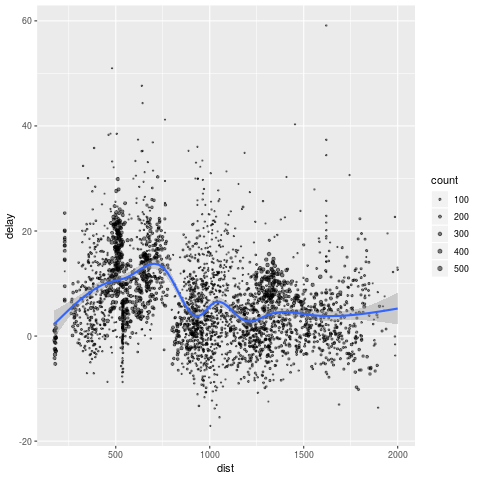

In [48]:
%%R 
delay <- flights_tbl %>% 
  group_by(tailnum) %>%
  summarise(count = n(), dist = mean(distance), delay = mean(arr_delay)) %>%
  filter(count > 20, dist < 2000, !is.na(delay)) %>%
  collect

# plot delays
library(ggplot2)
ggplot(delay, aes(dist, delay)) +
  geom_point(aes(size = count), alpha = 1/2) +
  geom_smooth() +
  scale_size_area(max_size = 2)

In [49]:
%%R 
batting_tbl %>% head()

# Source:   lazy query [?? x 22]
# Database: spark_connection
  playerID yearID stint teamID lgID      G    AB     R     H   X2B   X3B    HR
  <chr>     <int> <int> <chr>  <chr> <int> <int> <int> <int> <int> <int> <int>
1 abercda…   1871     1 TRO    NA        1     4     0     0     0     0     0
2 addybo01   1871     1 RC1    NA       25   118    30    32     6     0     0
3 allisar…   1871     1 CL1    NA       29   137    28    40     4     5     0
4 allisdo…   1871     1 WS3    NA       27   133    28    44    10     2     2
5 ansonca…   1871     1 RC1    NA       25   120    29    39    11     3     0
6 armstbo…   1871     1 FW1    NA       12    49     9    11     2     1     0
# ... with 10 more variables: RBI <int>, SB <int>, CS <int>, BB <int>,
#   SO <int>, IBB <int>, HBP <int>, SH <int>, SF <int>, GIDP <int>


In [50]:
%%R 
batting_tbl %>%
  select(playerID, yearID, teamID, G, AB:H) %>%
  arrange(playerID, yearID, teamID) %>%
  group_by(playerID) #%>%
  #filter(min_rank(desc(H)) <= 2 , H > 0)

# Source:     lazy query [?? x 7]
# Database:   spark_connection
# Groups:     playerID
# Ordered by: playerID, yearID, teamID
   playerID  yearID teamID     G    AB     R     H
   <chr>      <int> <chr>  <int> <int> <int> <int>
 1 aardsda01   2004 SFN       11     0     0     0
 2 aardsda01   2006 CHN       45     2     0     0
 3 aardsda01   2007 CHA       25     0     0     0
 4 aardsda01   2008 BOS       47     1     0     0
 5 aardsda01   2009 SEA       73     0     0     0
 6 aardsda01   2010 SEA       53     0     0     0
 7 aardsda01   2012 NYA        1     0     0     0
 8 aardsda01   2013 NYN       43     0     0     0
 9 aardsda01   2015 ATL       33     1     0     0
10 aaronha01   1954 ML1      122   468    58   131
# ... with more rows


## USING SQL

In [51]:
%%R 
library(DBI)
iris_preview <- dbGetQuery(sc, "SELECT * FROM iris LIMIT 10")
iris_preview

   Sepal_Length Sepal_Width Petal_Length Petal_Width Species
1           5,1         3,5          1,4         0,2  setosa
2           4,9         3,0          1,4         0,2  setosa
3           4,7         3,2          1,3         0,2  setosa
4           4,6         3,1          1,5         0,2  setosa
5           5,0         3,6          1,4         0,2  setosa
6           5,4         3,9          1,7         0,4  setosa
7           4,6         3,4          1,4         0,3  setosa
8           5,0         3,4          1,5         0,2  setosa
9           4,4         2,9          1,4         0,2  setosa
10          4,9         3,1          1,5         0,1  setosa


## mORE IN https://spark.rstudio.com/

## Advanced Analytics and Machine Learning

* Preprocessing your data (cleaning data and feature engineering)
* Supervised Learning
* Unsupervised Learning
* Recommendation Engines
* Graph Analysis
* Deep Learning


## What is MLlib?

MLlib is a package, built on and included in Spark, that provides interfaces for
* gathering and cleaning data,
* feature engineering and feature selection,
* training and tuning large scale supervised and unsupervised machine learning models,
* and using those models in production.
MLlib helps with all three steps of the process although it really shines in steps one and two for reasons that we will
touch on shortly.

The most common that you will come across is the Vector. Whenever we pass a set of features into a
machine learning model, we must do it as a vector that consists of Doubles. This vector can be either sparse (where
most of the elements are zero) or dense (where there are many unique values). These are specified in different ways,
one where we specify the exact values(dense) and the other where we specify the total size and which values are
nonzero(sparse). Sparse is appropriate, as you might have guessed, when the majority of the values are zero as this is
a more compressed representation that other formats.

In [52]:
from pyspark.ml.linalg import Vectors
denseVec = Vectors.dense(1.0, 2.0, 3.0)
size = 3
idx = [1, 2]
# locations in vector
values = [2.0, 3.0]
sparseVec = Vectors.sparse(size, idx, values)
# sparseVec.toDense() # these two don’t work, not sure why
# denseVec.toSparse() # will debug later

In [53]:
sparseVec

SparseVector(3, {1: 2.0, 2: 3.0})

## MLlib in Action

In [54]:
df = spark.read.json("Spark-The-Definitive-Guide-master/data/simple-ml")
df.orderBy("value2").show()

+-----+----+------+------------------+
|color| lab|value1|            value2|
+-----+----+------+------------------+
|green|good|     1|14.386294994851129|
|green| bad|    16|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|green| bad|    16|14.386294994851129|
|green|good|    12|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red| bad|     2|14.386294994851129|
|  red| bad|    16|14.386294994851129|
|  red| bad|    16|14.386294994851129|
| blue| bad|     8|14.386294994851129|
|green|good|     1|14.386294994851129|
|green|good|    12|14.386294994851129|
| blue| bad|     8|14.386294994851129|
|  red|good|    35|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|  red| bad|    16|14.386294994851129|
|green|good|    12|14.386294994851129|
+-----+----+------+------------------+
only showing top 20 rows



This dataset consists of a categorical label with two values, a categorical variable (color), and two numerical variables.
While the data is synthetic, an example of when this data might be used would be to predict customer health at a
company. The label represents their true current health, the color represents a rating before a phone call to determine
their true health and the two values represent some sort of usage metric. You should immediately recognize that this
will be a classification task where we hope to predict our binary output variable based on the inputs.

In [55]:
#libsvmData = spark.read.format("libsvm")\
#.load("Spark-The-Definitive-Guide-master/data/sample_libsvm_data.txt")

## Transformers
As we mentioned, transformer will help us manipulate our current columns in one way or another. These columns,
in machine learning terminology, represent features (that we will input into our model) and in our particular case, a
label that represents the correct output. Transformers exist to either cut down on the number of features, add more
features, manipulate current ones or simply help us format our data correctly. In general, transformers add new
columns to DataFrames.

To achieve this, we are going to do this by specifying an RFormula. This is a declarative language for specifying
machine learning models and is incredibly simple to use once you understand the syntax. Currently RFormula
supports a limited subset of the R operators that in practice work quite well for simple models. The basic operators
are:
* ~ separate target and terms;
* + concat terms, "+ 0" means removing the intercept (this means that the y-intercept of the line that we will fit
will be 0.);
* - remove a term, "- 1" means removing intercept (this means that the y-intercept of the line that we will fit will
be 0. Yes, this does the same thing as the bullet above.);
* : interaction (multiplication for numeric values, or binarized categorical values);
* . all columns except the target/dependant variable.


In [56]:
from pyspark.ml.feature import RFormula

Then we go through the process of defining our formula. In this case we want to use all available variables (the .) and
then specify a interactions between value1 and color and value2 and color.

In [57]:
supervised = RFormula(formula= "lab~ . + color:value1 + color:value2" )

In [58]:
fittedRF = supervised.fit(df)
preparedDF = fittedRF.transform(df)
preparedDF.show()

+-----+----+------+------------------+--------------------+-----+
|color| lab|value1|            value2|            features|label|
+-----+----+------+------------------+--------------------+-----+
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| bad|     8|14.386294994851129|(10,[2,3,6,9],[8....|  0.0|
| blue| bad|    12|14.386294994851129|(10,[2,3,6,9],[12...|  0.0|
|green|good|    15| 38.97187133755819|(10,[1,2,3,5,8],[...|  1.0|
|green|good|    12|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
|green| bad|    16|14.386294994851129|(10,[1,2,3,5,8],[...|  0.0|
|  red|good|    35|14.386294994851129|(10,[0,2,3,4,7],[...|  1.0|
|  red| bad|     1| 38.97187133755819|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|     2|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|    16|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red|good|    45| 38.97187133755819|(10,[0,2,3,4,7],[...|  1.0|
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| ba

In [59]:
train, test = preparedDF.randomSplit([0.7, 0.3])

## Estimators
Now that we transformed our data into the correct format and created some valuable features. It’s time to actually
fit our model. In this case we will use logistic regression.

In [60]:

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(
labelCol= "label" ,
featuresCol= "features" )

In [61]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [62]:
fittedLR = lr.fit(train)

In [63]:
fittedLR.transform(train).select( "label" ,"prediction" ).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



## Pipelining our Workflow

In [64]:
train, test = df.randomSplit([0.7, 0.3])
rForm = RFormula()

In [65]:
lr = LogisticRegression()\
.setLabelCol( "label" )\
.setFeaturesCol( "features" )

In [66]:
from pyspark.ml import Pipeline
stages = [rForm, lr]
pipeline = Pipeline().setStages(stages)

The next step will be evaluating the performance of this pipeline.
Spark does this by setting up a parameter grid of all the combinations of the parameters that you specify. You
should immediately notice in the following code snippet that even our RFormula is tuning specific parameters.
In a pipeline, we can modify more than just the model’s hyperparameters, we can even modify the transformer’s
properties.

In our current grid there are three hyperparameters that will diverge from the defaults.
* two different options for the R formula
* three different options for the elastic net parameter
* two different options for the regularization parameter

In [67]:
from pyspark.ml.tuning import ParamGridBuilder
params = ParamGridBuilder()\
.addGrid(rForm.formula, [
"lab ~ . + color:value1",
"lab ~ . + color:value1 + color:value2"])\
.addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
.addGrid(lr.regParam, [0.1, 2.0])\
.build()

This gives us a total of twelve different combinations of these parameters, which means we will be training twelve
different versions of logistic regression.

With the grid built it is now time to specify our evaluation. There are evaluators for classification and regression, which
we cover in subsequent chapters. In this case, we will be using the BinaryClassificationEvaluator. This
evaluator allows us to automatically optimize our model training according to some specific criteria that we specify.
In this case we will specify areaUnderROC which is the total area under the receiver operating characteristic a very
common measure of classification performance that we cover in the classification chapte

In [68]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()\
.setMetricName( "areaUnderROC" )\
.setRawPredictionCol( "prediction" )\
.setLabelCol( "label" )

As you may know, it is a best practice in machine learning to fit your hyperparameters on a validation set (instead of
your test set). The reasons for this are to prevent overfitting. Therefore we cannot use our holdout test set (that we
created before) to tune these parameters. Luckily Spark provides two options for performing this hyperparameter
tuning in an automated way. We can use a TrainValidationSplit, which will simply perform an arbitrary
random split of our data into two different groups, or a CrossValidator, which performs K-fold cross validation by
splitting the dataset into k non-overlapping randomly partitioned folds.

In [69]:
from pyspark.ml.tuning import TrainValidationSplit
tvs = TrainValidationSplit()\
.setTrainRatio(0.75)\
.setEstimatorParamMaps(params)\
.setEstimator(pipeline)\
.setEvaluator(evaluator)

Now we can fit our entire pipeline. This will test out every version of the model against the validation set. You will
notice that the the type of tvsFitted is TrainValidationSplitModel. Any time that we fit a given model, it
outputs a "model" type.

In [70]:
tvsFitted = tvs.fit(train)

In [71]:
evaluator.evaluate(tvsFitted.transform(test))

0.9117647058823529

## Deployment Patterns

1. Train your ML algorithm offline and then put the results into a database (usually a key-value store). This works
well for something like recommendation but poorly for something like classification or regression where you
cannot just lookup a value for a given user but must calculate one.
2. Train your ML algorithm offline, persist the model to disk, then use that for serving. This is not a low latency
solution as the overhead of starting up a Spark job can be quite high - even if you’re not running on a cluster.
Additionally this does not parallelize well, so you’ll likely have to put a load balancer in front of multiple model
replicas and build out some REST API integration yourself. There are some interesting potential solutions to
this problem, but nothing quite production ready yet.
3. Manually (or via some other software) convert your distributed model to one that can run much more quickly
on a single machine. This works well when there is not too much manipulation of the raw data in Spark and
can be hard to maintain over time. Again there are solutions that are working on this specification as well
but nothing production ready. This cannot be found in the previous illustration because it’s something that
requires manual work.
4. Train your ML algorithm online and use it online, this is possible when used in conjunction like streaming but
is quite sophisticated. This landscape will likely continue to mature as Structured Streaming development
continues.

## Graph Analysis

his chapter is going to dive
into a more specialized toolset: graph processing. In
the context of graphs, nodes or vertices are the units
while edges define the relationships between those
nodes. The process of graph analysis is the process of
analyzing these relationships. An example graph might
be your friend group, in the context of graph analysis
each vertex or node would represent a person and each
edge would represent a relationship.


Graph are a natural
way of describing relationships and many different
problem sets and Spark provides several ways of
working in this analytics paradigm. Some business use
cases could be detecting credit card fraud, importance
of papers in bibliographic networks [which papers are
most referenced], and ranking web pages as Google
famously used the PageRank algorithm to do.

In [5]:
bikeStations = spark.read\
.option("header","true")\
.csv("Spark-The-Definitive-Guide-master/data/bike-data/201508_station_data.csv")
tripData = spark.read\
.option("header","true")\
.csv("Spark-The-Definitive-Guide-master/data/bike-data/201508_trip_data.csv")

## Building A Graph
The first step is to build the graph, to do this we need to define the vertices and edges. In our case we’re creating
a directed graph. This graph will point from the source to the location. In the context of this bike trip data, this will
point from a trip’s starting location to a trip’s ending location.To define the graph, we use the naming conventions
presented in the GraphFrames library. In the vertices table we define our identifier as id and in the edges table we
label the source id as src and the destination id as dst.

This is not working in python. alternative: scala

In [6]:
stationVertices = bikeStations\
.withColumnRenamed("name", "id")\
.distinct()
tripEdges = tripData\
.withColumnRenamed("Start Station", "src")\
.withColumnRenamed("End Station", "dst")

This allows us to build out graph out of the DataFrames we have so far. We will also leverage caching because we’ll be
accessing this data frequently in the following queries.

In [7]:
#from graphframes import GraphFrame
from graphframes import GraphFrame 

In [8]:
GraphFrame(stationVertices, tripEdges)
#stationGraph.cache()

Py4JJavaError: An error occurred while calling o61.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.net.URLClassLoader.findClass(URLClassLoader.java:381)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:424)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:357)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


## MLlib Neural Network Support

Spark’s MLlib currently has native support for one deep learning algorithm, the multilayer perceptron classifier in the
ml.classification.MultilayerPerceptronClassifier class. This class is limited to training relatively
shallow networks containing fully connected layers with the sigmoid activation function, and an output layer with
a softmax activation function. This class is most useful for training the last few layers of a classification model when
using transfer learning on top of an existing deep learning based featurizer. For example, it can be added on top of the
Deep Learning Pipelines library we describe later in this chapter to quickly perform transfer learning over Keras and TensorFlow models. However, the MultiLayerPerceptronClassifier alone is not enough to train a deep learning model
from scratch on raw input data.

## IMAGES

One of the historical challenges when it came to working with images in Spark is that getting them into a DataFrame
was difficult and tedious. Deep Learning Pipelines includes utility functions that making loading and decoding images
in a distributed fashion easy.

In [5]:
from sparkdl import readImages

Using TensorFlow backend.


In [6]:
img_dir = 'Spark-The-Definitive-Guide-master/data/deep-learning-images/'
image_df = readImages(img_dir)

In [7]:
image_df.show()
image_df.printSchema()

+--------------------+-----+
|            filePath|image|
+--------------------+-----+
|file:/home/erikap...| null|
+--------------------+-----+

root
 |-- filePath: string (nullable = false)
 |-- image: struct (nullable = true)
 |    |-- mode: string (nullable = false)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- data: binary (nullable = false)



## Transfer Learning

Now that we have some data, we can get started with some simple transfer learning. Remember, this means
leveraging a model that someone else created and modifying it to better suit our own purposes. First we will load the
data for each type of flower and create a training and a test set.

In [8]:
from sparkdl import readImages
from pyspark.sql.functions import lit
tulips_df = readImages(img_dir + "/tulips").withColumn("label", lit(1))
daisy_df = readImages(img_dir + "/daisy").withColumn("label", lit(0))
tulips_train, tulips_test = tulips_df.randomSplit([0.6, 0.4])
daisy_train, daisy_test = daisy_df.randomSplit([0.6, 0.4])
train_df = tulips_train.unionAll(daisy_train)
test_df = tulips_test.unionAll(daisy_test)

The next step will be to leverage a transformer called the DeepImageFeaturizer. This will allow us to leverage a
pre-trained model called Inception, a powerful neural network successfully used to identify patterns in images. The
version were are using is pre-trained to work well with images. This is a part of the standard pretrained models that
ship with the Keras library. However, this particular neural network is not trained to work with our particular set of
images (involving flowers). Therefore we’re going to use transfer learning in order to make it into something useful for
our own purposes.
One thing that’s quite powerful here is that we can use the same ML pipeline concepts that we saw throughout this
part of the book and leverage them with Deep Learning: DeepImageFeaturizer is just a Spark ML transformer.
Additionally, all that we’ve done to extend this model is add on a logistic regression model in order to facilitate the
training of our end model. We could use another classifier in its place.

In [9]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer
featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
lr = LogisticRegression(maxIter=1, regParam=0.05, elasticNetParam=0.3, labelCol="label")
p = Pipeline(stages=[featurizer, lr])
p_model = p.fit(train_df)

INFO:tensorflow:Froze 376 variables.


2019-02-13 13:55:26,807 INFO (MainThread-6629) Froze 376 variables.


INFO:tensorflow:Converted 376 variables to const ops.


2019-02-13 13:55:27,042 INFO (MainThread-6629) Converted 376 variables to const ops.


INFO:tensorflow:Froze 0 variables.


2019-02-13 13:55:54,473 INFO (MainThread-6629) Froze 0 variables.


INFO:tensorflow:Converted 0 variables to const ops.


2019-02-13 13:55:54,591 INFO (MainThread-6629) Converted 0 variables to const ops.
2019-02-13 13:55:55,010 INFO (MainThread-6629) Fetch names: ['sdl_flattened_mixed10/concat:0']
2019-02-13 13:55:55,013 INFO (MainThread-6629) Spark context = <SparkContext master=local[*] appName=pyspark_python>


Py4JJavaError: An error occurred while calling o235.loadClass.
: java.lang.ClassNotFoundException: org.tensorframes.impl.DebugRowOps
	at java.net.URLClassLoader.findClass(URLClassLoader.java:381)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:424)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:357)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


Once we trained the model, we can use the same classification evaluator that we saw several chapters ago. We can
specify the metric we’d like to test and then test against that.

In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
tested_df = p_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(tested_df.select("prediction", "label"))))

NameError: name 'p_model' is not defined

With our DataFrame of examples, we can inspect the rows and images in which we made mistakes in the previous
training.

In [19]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import expr
# a simple UDF to convert the value to a double
def _p1 (v):
    return float(v.array[1])


In [20]:
p1 = udf(_p1, DoubleType())


AttributeError: 'DoubleType' object has no attribute 'array'

In [21]:
df = tested_df.withColumn("p_1", p1(tested_df.probability))
wrong_df = df.orderBy(expr("abs(p_1 - label)"), ascending=False)
wrong_df.select("filePath", "p_1", "label").limit(10).show()

NameError: name 'tested_df' is not defined